In [1]:
import torch
import torchaudio

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio

In [2]:
from mir_eval import separation
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.utils import download_asset

## Construct Model Pipeline

demucs = HDEMUCS_HIGH_MUSDB_PLUS
model = demucs.get_model()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

samp_rate = demucs.sample_rate

print("Sample Rate: {}".format(samp_rate))
print("Device: {}".format(device))

Sample Rate: 44100
Device: cpu


In [3]:
## Method tools
from torchaudio.transforms import Fade

### Source separation idea
def separate_sources(
    model,
    mix,
    segment=10.0,
    overlap=0.1,
    device=None,
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """
    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    chunk_len = int(sample_rate * segment * (1 + overlap))
    start = 0
    end = chunk_len
    overlap_frames = overlap * sample_rate
    fade = Fade(fade_in_len=0, fade_out_len=int(overlap_frames), fade_shape="linear")

    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model.forward(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out
        if start == 0:
            fade.fade_in_len = int(overlap_frames)
            start += int(chunk_len - overlap_frames)
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0
    return final


def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-60, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

In [4]:
SAMPLE_SONG = download_asset("tutorial-assets/hdemucs_mix.wav")
waveform, sample_rate = torchaudio.load(SAMPLE_SONG)  # replace SAMPLE_SONG with desired path for different song
waveform = waveform.to(device)
mixture = waveform

# parameters
segment = 10
overlap = 0.1

print("Separating track")

ref = waveform.mean(0)
waveform = (waveform - ref.mean()) / ref.std()  # normalization

sources = separate_sources(
    model,
    waveform[None],
    device=device,
    segment=segment,
    overlap=overlap,
)[0]
sources = sources * ref.std() + ref.mean()

sources_list = model.sources
sources = list(sources)

audios = dict(zip(sources_list, sources))

Separating track


In [5]:
N_FFT = 4096
N_HOP = 4
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)

def output_results(original_source: torch.Tensor, predicted_source: torch.Tensor, source: str):
    print(
        "SDR score is:",
        separation.bss_eval_sources(original_source.detach().numpy(), predicted_source.detach().numpy())[0].mean(),
    )
    plot_spectrogram(stft(predicted_source)[0], f"Spectrogram {source}")
    return Audio(predicted_source, rate=sample_rate)


segment_start = 150
segment_end = 155

frame_start = segment_start * sample_rate
frame_end = segment_end * sample_rate

drums_original = download_asset("tutorial-assets/hdemucs_drums_segment.wav")
bass_original = download_asset("tutorial-assets/hdemucs_bass_segment.wav")
vocals_original = download_asset("tutorial-assets/hdemucs_vocals_segment.wav")
other_original = download_asset("tutorial-assets/hdemucs_other_segment.wav")

drums_spec = audios["drums"][:, frame_start:frame_end].cpu()
drums, sample_rate = torchaudio.load(drums_original)

bass_spec = audios["bass"][:, frame_start:frame_end].cpu()
bass, sample_rate = torchaudio.load(bass_original)

vocals_spec = audios["vocals"][:, frame_start:frame_end].cpu()
vocals, sample_rate = torchaudio.load(vocals_original)

other_spec = audios["other"][:, frame_start:frame_end].cpu()
other, sample_rate = torchaudio.load(other_original)

mix_spec = mixture[:, frame_start:frame_end].cpu()

SDR score is: 5.0177358218049495


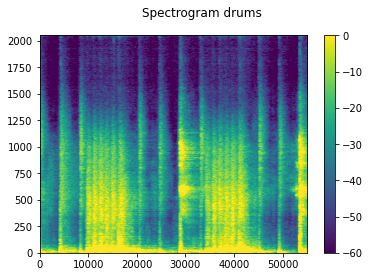

SDR score is: 18.90925234159012


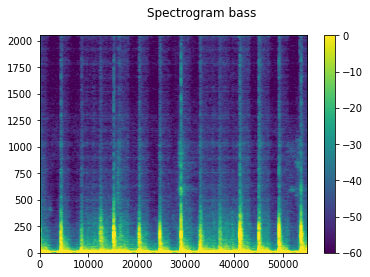

SDR score is: 8.792410952839973


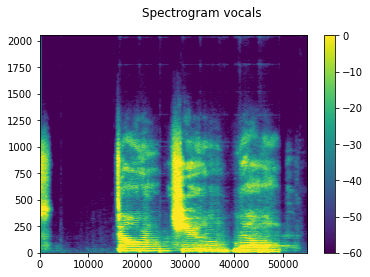

SDR score is: 8.868966852103188


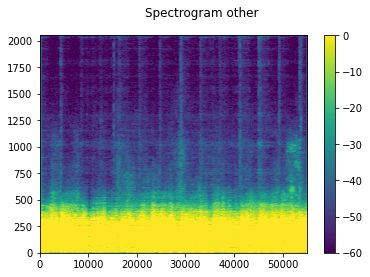

In [6]:
Audio(mix_spec, rate=sample_rate)
# Drums Clip
output_results(drums, drums_spec, "drums")
# Bass Clip
output_results(bass, bass_spec, "bass")
# Vocals Audio
output_results(vocals, vocals_spec, "vocals")
# Other Clip
output_results(other, other_spec, "other")